<a href="https://colab.research.google.com/github/Evangeline111/Neural_Tangent_Kernel_Huiyao_Wang/blob/main/Dissertation_Neural_Tangent_Kernel_Huiyao_Wang.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Neural Tanget Kernal : using Neural Tangents packages.

In [1]:
!pip install -q --upgrade pip
!pip install -q --upgrade jax[cuda11_cudnn805] -f https://storage.googleapis.com/jax-releases/jax_cuda_releases.html
!pip install -q git+https://www.github.com/google/neural-tangents

     |████████████████████████████████| 2.0 MB 4.2 MB/s 
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 12.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 250.7/250.7 MB 4.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.5/99.5 kB 4.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.8/67.8 kB 7.7 MB/s eta 0:00:00


In [2]:
from jax.example_libraries import optimizers
from jax import jit, grad
import jax.numpy as np
from jax import random
import numpy as npy
import functools
import neural_tangents as nt
from neural_tangents import stax, predict
import matplotlib
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

### **Step One: Create the Dataframe and Define the Fully-connected Neural Networks**

We will generate our training data and testing data from the process $y=f(x)+ϵ$. $f(x)$ is a deterministic function and $\epsilon\sim\mathcal N(0, 0.1)$ is Gaussian noise. 
*  training data is from $f(x) = \sin(x)x^2$ with $x\sim\text{Uniform}(-5,5)$. 
*  testing data is from $y = f(x)$ with $x$ linearly spaced in $[-5, 5]$.

We will use the data including 200 training points and 50 testing points 

In [3]:
training_point = 200
testing_point = 50
noise = 1e-1

# function: sin(x)*x*x
fitting_function = lambda x: np.sin(x)*x*x
# step one: generate train data
# uniformly generate trainX which belongs to [-5,5]
trainX = npy.random.uniform(low=-5, high=5, size=training_point)
# insert to the function sin(x)*x*x and then get trainY
trainY = fitting_function(trainX)
# for adding some noise
mu, sigma = 0, 0.1 # mean and standard deviation
trainY += noise * npy.random.normal(mu, sigma, size=training_point)
trainX = np.reshape(trainX, (training_point, 1))
trainY = np.reshape(trainY, (training_point, 1))
# return number: start from -5 end at 5，interval=testing points
testX = np.linspace(-5, 5, testing_point)
# reshape and get the dimension of the testX (50,1)
testX = np.reshape(testX, (testing_point, 1))
testY = fitting_function(testX)

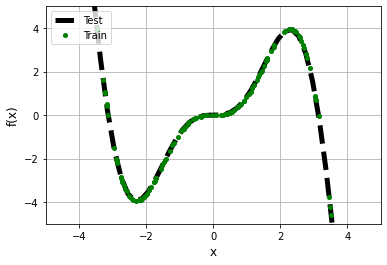

In [4]:
# plot the figure of dataset
plt.figure() 
myfig = plt.gcf()
plt.plot(testX, testY, 'k--', linewidth=5)# black line: testing data
plt.plot(trainX, trainY, 'go', markersize=4)# green line: training data
plt.xlim([-5., 5.])
plt.ylim([-5., 5.])
plt.grid()
plt.xlabel("x", fontsize=12)
plt.ylabel("f(x)", fontsize=12)
plt.legend(['Test', 'Train'],loc='upper left')
myfig.savefig('function.png',dpi=300)

**Defining the fully-connected neural networks**




*   L-hidden-layer network,L=1,2,3...
*   weight=1.0, bias=0.05
*   nonlinearities: ReLU or Erf


Fully-connected layers can be created by using `neural_tangents.stax`. `stax.Dense` is used to define fully-connected layer,

$f^{(l+1)}(x;\theta)=\frac{1}{\sqrt{n_l}}W^{(l)}x^{(l)}(x;\theta)+\beta b^{(l)}$, where $W_{ij}, b_i\sim\mathcal N(0,1)$ at initialization.

Neural Tangents packages can extend the `(init_fn, apply_fn)` tuple to a triple `(init_fn, apply_fn, kernel_fn)`.


*   `init_fn(key, input_shape)` is to initialize the trainable parameters.
*   `apply_fn(params, xs)`is to compute outputs of the network for specific inputs.
*   `kernel = kernel_fn(x_1, x_2)`is the kernel function of the infinite network Guassion Process.

`kernel_fn` compute two covariance matrices corresponding to the Neural Network Gaussian Process (NNGP) and Neural Tangent kernels respectively. The NNGP kernel corresponds to the Bayesian infinite neural network. The NTK corresponds to the (continuous) gradient descent trained infinite network. 

In [5]:
# a simple fully-connected network using ReLU or Erf nonlinearities
# output: init_fn(key, input_shape) is to initialize the trainable parameters.
# apply_fn(params, xs) computes outputs of the network for inputs. 
# the third function, kernel_fn, computes infinite-width Gaussian process kernels corresponding to the layer. 
# Layer constructor function is a dense (fully-connected) layer.
# number of neurons: 8 16 32 64 128 256 512 1024 2048 4096
init_fn, apply_fn, kernel_fn = stax.serial(
    stax.Dense(1024, W_std=1, b_std=0.05), stax.Erf(),
    stax.Dense(1, W_std=1, b_std=0.05)
)
# jit: sets up function for just-in-time compilation with XLA.
# apply_fn and kernel_fn is the function to be jitted
apply_fn = jit(apply_fn)
kernel_fn = jit(kernel_fn, static_argnames='get')
# use a JAX feature that compiles functions so that they are executed as single calls to the GPU.

## Step Two: How to Compute the Neural Tangent Kernel and Do Predictions:

  `kernel_fns = {
      'nngp': empirical_nngp_fn(**kwargs),
      'ntk': empirical_ntk_fn(**kwargs, **ntk_kwargs)
  }`

`empirical_ntk_fn`: The Neural Tangent Kernel is defined as :`J(X_1)J(X_2)^T` ,where `J` is the Jacobian.


The empirical NTK for two data points $x_1$ and $x_2$ is defined as the matrix product between the Jacobian of the model evaluated at $x_1$ and the Jacobian of the model evaluated at $x_2$:  $J(x_1)J(x_2)^{T}$. In the batched case where $x_1$ is a batch of data points and $x_2$ is a batch of data points, then we want the matrix product between the Jacobians of all combinations of data points from and and $x_1$  and $x_2$.

For two input data sequences $x$ and $x'$, the NTK is defined as(Jacot al.2018):$\Theta_s(x,x')=\left\langle \nabla_{\theta_{s}}f_{\theta_{s}}(x),\nabla_{\theta_{s}}f_{\theta_{s}}(x')\right\rangle$, where $f_{\theta_{s}}$ and $\theta_{s}$ are the network output and parameters during training at time s.

  






Here, we compute the result of doing gradient descent on our infinite network for an infinite amount of time by using the "NTK" inference mode.





In [6]:
a = []
key = random.PRNGKey(10)
for _ in range(10):
  key, net_key = random.split(key)
  _, params = init_fn(net_key, (-1, 1))
  a += [apply_fn(params, testX)]

In [7]:
# example
NTK = kernel_fn(testX, testX, 'ntk')
std_dev = np.sqrt(np.diag(NTK))

In [8]:
np.shape(NTK)

(50, 50)

**predict function** :predictions with infinite networks
* `predict.gradient_descent_mse `- inference with a single infinite width / linearized network trained on MSE loss with continuous gradient descent for an arbitrary finite or infinite (`t=None`) time. Computed in closed form.

* `predict.gradient_descent` - inference with a single infinite width / linearized network trained on arbitrary loss with continuous (momentum) gradient descent for an arbitrary finite time. Computed using an ODE solver.

* `predict.gradient_descent_mse_ensemble` - inference with an infinite ensemble of infinite width networks, either fully Bayesian (`get='nngp'`) or **inference with MSE loss using continuous gradient descent(`get='ntk'`).** Finite-time Bayesian inference(e.g.`t=1`, `get='nngp'`) is interpreted as gradient descent on the top layer only, since it converges to exact Gaussian process inference with NNGP (`t=None, get='nngp'`). Computed in closed form.

* `predict.gp_inference` - exact closed form Gaussian process inference using NNGP (`get='nngp'`), NTK (`get='ntk'`), or both (get=(`'nngp', 'ntk'`)). Equivalent to predict.gradient_descent_mse_ensemble with `t=None` (infinite training time), but has a slightly different API (accepting precomputed kernel matrix `k_train_train` instead of `kernel_fn` and `x_train`).



`predict_fn` function also includes two different modes: 


*   "NNGP" model: compute the Bayesian posterior(which is equivalent to gradient descent with all but the last-layer weights frozen).
*   "NTK" model: compute the distribution of networks after gradient descent training.




In [9]:
predict_fn = nt.predict.gradient_descent_mse_ensemble(kernel_fn, trainX, trainY, diag_reg=1e-3)

# to computes the mean and covariance of the network evaluated on the test points after training
ntk_mean_y, ntk_cov = predict_fn(x_test=testX, get='ntk', compute_cov=True)
# the dimension of ntk_mean is (50,1)
testScore = (mean_squared_error(testY[:,0],ntk_mean_y[:,0]))
# np.reshape(ntk_mean, (-1,1)) means column is one, row is unknown
ntk_mean = np.reshape(ntk_mean_y, (-1,))
ntk_std = np.sqrt(np.diag(ntk_cov))
# after reshape (50,)
testScore

0.25767368

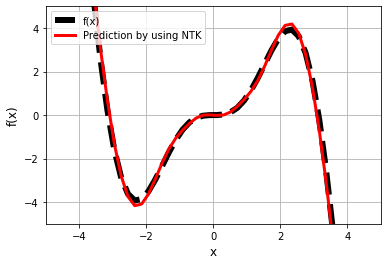

In [10]:
plt.figure() # creat a new figure
myfig = plt.gcf()
plt.plot(testX, testY, 'k--', linewidth=6)
plt.plot(testX, ntk_mean, 'r-', linewidth=3)# solid line
plt.xlim([-5., 5.])
plt.ylim([-5., 5.])
plt.grid()
plt.xlabel("x", fontsize=12)
plt.ylabel("f(x)", fontsize=12)
plt.legend(['f(x)', 'Prediction by using NTK'],loc='upper left')
myfig.savefig('one4096Erf1.png',dpi=300)

In [11]:
# define a MSE loss function to compute MSE loss for training and testing data
def MSE_loss(predict_fn, Y, time, X=None):
  Mean, Cov = predict_fn(t=time, get='ntk', x_test=X, compute_cov=True)
  mean = np.reshape(Mean, Mean.shape[:1] + (-1,))#(n,-1)
  var = np.diagonal(Cov, axis1=1, axis2=2)
  Y = np.reshape(Y, (1, -1))
  mean_loss = 0.5 * np.mean((Y-mean)**2+ var, axis=1)

  return mean_loss

# set step from 0 to 1000, step size:0.1
time = np.arange(0, 10 ** 3, 10 ** -1)
training_loss_ntk = MSE_loss(predict_fn, trainY, time)
testing_loss_ntk = MSE_loss(predict_fn, testY, time, testX)

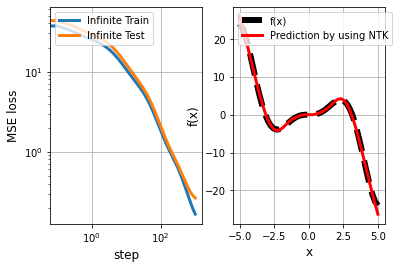

In [12]:
plt.figure() # creat a new figure
myfig = plt.gcf()

plt.subplot(1, 2, 1)
plt.loglog(time, training_loss_ntk, linewidth=3)
plt.loglog(time, testing_loss_ntk, linewidth=3)
plt.legend(['Infinite Train', 'Infinite Test'],loc='upper left')
plt.xlabel("step", fontsize=12)
plt.ylabel("MSE loss", fontsize=12)
plt.grid()
plt.subplot(1, 2, 2)
plt.plot(testX, testY, 'k--', linewidth=6)
plt.plot(testX, ntk_mean, 'r-', linewidth=3)# solid line
plt.legend(['f(x)','Prediction by using NTK'],loc='upper left')
plt.grid()
plt.xlabel("x", fontsize=12)
plt.ylabel("f(x)", fontsize=12)
myfig.savefig('one4096Erf1.png',dpi=300)

## Comparing with the results of Neural Networks training by gradient descent

Here we use JAX packages to train with gradient descent. We use `optimizer`, which is composed by functions `(init_fn, update_fn, get_params)`. 
*  `init_fn(params)` takes the initial set of parameters and returns an optimizer state that can include extra information.
*  `opt_update(step, grads, state)` takes a new state and updates it using gradients. 
*  `get_params(state)` returns the parameters for a given state.

Step one: define a loss and a gradient of the loss.

We train the networks by gradient descent on the MSE Loss. The function `grad` is the JAX function, which can return the gradient of the function. 

Step two: train the network.

After initialising the optimizer state, we update it 10,000 times, and after each update, we record the train and test loss.

Step three: define `train_network` function and train an ensemble network.


In [13]:
learning_rate = 0.1
training_steps = 10000

opt_initial, opt_update, get_params = optimizers.sgd(learning_rate)
# jit: sets up function for just-in-time compilation with XLA.
# opt_update is the function to be jitted
opt_update = jit(opt_update)
train = (trainX, trainY)
test = (testX, testY)

In [14]:
train_loss = []
test_loss = []
loss = lambda params, x, y: 0.5 * np.mean((apply_fn(params, x) - y) ** 2)
gradient_loss = lambda state, x, y: grad(loss)(get_params(state), x, y)
loss = jit(loss)
gradient_loss = jit(gradient_loss)
opt_state = opt_initial(params)

#opt_update(step, grads, state) takes a new state and updates it using gradients.
for i in range(training_steps):
  opt_state = opt_update(i, gradient_loss(opt_state, *train), opt_state)

  train_loss += [loss(get_params(opt_state), *train)]
  test_loss += [loss(get_params(opt_state), *test)]

Text(0, 0.5, 'f(x)')

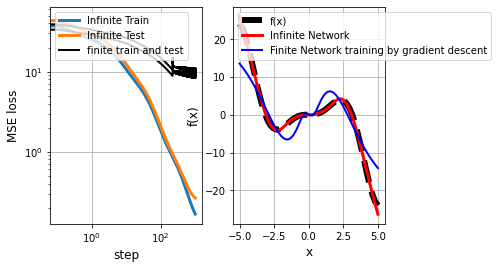

In [15]:
plt.figure() # creat a new figure
myfig = plt.gcf()

plt.subplot(1, 2, 1)
plt.loglog(time, training_loss_ntk, linewidth=3)
plt.loglog(time, testing_loss_ntk, linewidth=3)
plt.loglog(time, train_loss, 'k-', linewidth=2)
plt.loglog(time, test_loss, 'k-', linewidth=2)
plt.grid()
plt.xlabel("step", fontsize=12)
plt.ylabel("MSE loss", fontsize=12)
plt.legend(['Infinite Train', 'Infinite Test','finite train and test'],loc='upper left')
plt.subplot(1, 2, 2)
plt.plot(testX, testY, 'k--', linewidth=6)
plt.plot(testX, ntk_mean, 'r-', linewidth=3)# solid line
plt.plot(testX, apply_fn(get_params(opt_state), testX), 'b-', linewidth=2)
plt.legend(['f(x)','Infinite Network', 'Finite Network training by gradient descent'], loc='upper left')
plt.grid()
plt.xlabel("x", fontsize=12)
plt.ylabel("f(x)", fontsize=12)

In [16]:
trainGD=apply_fn(get_params(opt_state), testX)
#R2_GD=r2_score(test_ys[:,0],trainGD[:,0])
testScore_GD = (mean_squared_error(testY[:,0],trainGD[:,0]))
testScore_GD

19.989496

In [17]:
def train_network(key):
  train_losses = []
  test_losses = []

  _, params = init_fn(key, (-1, 1))
  opt_state = opt_initial(params)

  for i in range(training_steps):
    train_losses += [np.reshape(loss(get_params(opt_state), *train), (1,))]
    test_losses += [np.reshape(loss(get_params(opt_state), *test), (1,))]
    opt_state = opt_update(i, gradient_loss(opt_state, *train), opt_state)


  train_losses = np.concatenate(train_losses)
  test_losses = np.concatenate(test_losses)
  return get_params(opt_state), train_losses, test_losses

In [18]:
params, training_loss, testing_loss = train_network(key)

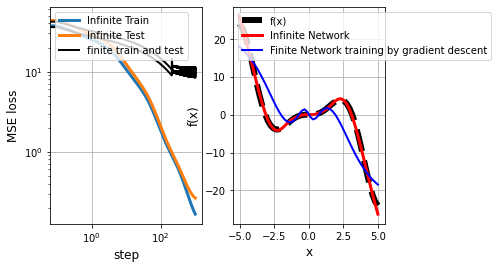

In [19]:
plt.figure() # creat a new figure
myfig = plt.gcf()

plt.subplot(1, 2, 1)
plt.loglog(time, training_loss_ntk, linewidth=3)
plt.loglog(time, testing_loss_ntk, linewidth=3)
plt.loglog(time, training_loss, 'k-', linewidth=2)
plt.loglog(time, testing_loss, 'k-', linewidth=2)
plt.grid()
plt.xlabel("step", fontsize=12)
plt.ylabel("MSE loss", fontsize=12)
plt.legend(['Infinite Train', 'Infinite Test','finite train and test'],loc='upper left')
plt.subplot(1, 2, 2)
plt.plot(testX, testY, 'k--', linewidth=6)
plt.plot(testX, ntk_mean, 'r-', linewidth=3)# solid line
plt.plot(testX, apply_fn(params, testX), 'b-', linewidth=2)
plt.legend(['f(x)','Infinite Network', 'Finite Network training by gradient descent'], loc='upper left')
plt.grid()
plt.xlabel("x", fontsize=12)
plt.ylabel("f(x)", fontsize=12)
myfig.savefig('one4096ErfGD1.png',dpi=300)